In [1]:
import torch
import cv2
import torchvision
from einops import repeat

from config import Config
from sd.full_model import FullModel
from sampler.ddpm import DDPMSampler
from PIL import Image, ImageDraw, ImageFont
from dataloader.dataset import WriterIdConverter
from utils import label_converter
from train import generate_image

In [2]:
def save_images(images, labels, path=None, latent=Config.latent, **kwargs):
    h, w = Config.img_size
    rows, cols = 2, 8
    background = Image.new('RGB', size=(cols*w, rows*h))
    if latent == True:
        font = cv2.FONT_HERSHEY_SIMPLEX

        for i, (image, label) in enumerate(zip(images, labels)):
            im = torchvision.transforms.ToPILImage()(image)
            draw = ImageDraw.Draw(im)
            font = ImageFont.truetype('arial.ttf',size=16)
            draw.text((0,0),label,(255,0,0),font=font)
            background.paste(im, box=(i%cols*w, i//cols*h))
    else:
        raise NotImplementedError
        # ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
        # im = Image.fromarray(ndarr)
    if path:
        background.save(path)
    return background

In [3]:
model = FullModel()
model.to(Config.device)
model.load_state_dict(torch.load('output_3/models/ckpt_5.pt'))

<All keys matched successfully>

In [4]:
generator = torch.Generator(device=Config.device)
sampler = DDPMSampler(generator, device=Config.device)
sampler.set_inference_timesteps(1000)

In [5]:
texts = ['move', 'getting', 'prop']
texts_tensor = label_converter(texts, to_tensor=True) # N_text x (1, L)
id_converter = WriterIdConverter()

In [6]:
from dataloader.dataset import IAMDataset


train_ds = IAMDataset(
        root=Config.dataset_root,
        label_path=Config.label_path
        # root='C:/Users/thanh/Python/WordStylist/data',
        # label_path='gt/train_samples'
    )

In [24]:
train_ds[2]

('049', <PIL.Image.Image image mode=RGB size=256x64>, 'the')

In [8]:
image_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

******************************************Generate sample*******************************************


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


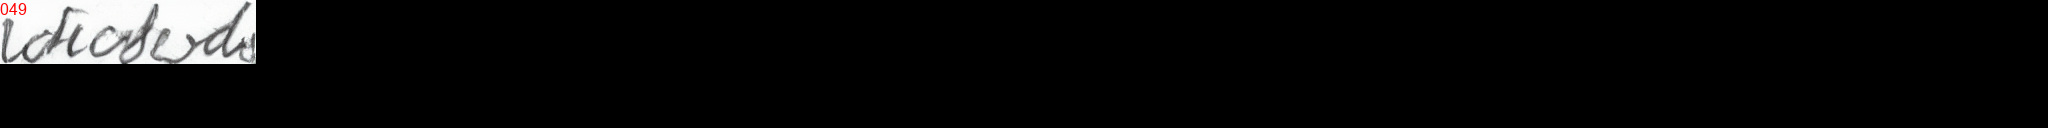

In [23]:
model.eval()
generator.manual_seed(42)
torch.manual_seed(42)
sampler.set_inference_timesteps(100)
with torch.no_grad():
    print('{:*^100}'.format('Generate sample'))
    # for i, text_ts in enumerate(texts_tensor[:1]):
    wid, img, text = train_ds[2]
    text_ts = label_converter([text], to_tensor=True)
    text_ts = text_ts[0].to(Config.device)
    # styles = torch.randint(0, 339, (16,)).to(Config.device)
    img_ref = image_transform(img)
    img_ref = img_ref[None,:].to(Config.device)
    styles = torch.tensor([id_converter.get_train_id(wid)]).to(Config.device)
    dup_text_ts = repeat(text_ts,'t l -> (b t) l', b=1)
    images = generate_image(dup_text_ts, img_ref, styles, model, sampler)
    wid = [id_converter.get_writer_id(id.item()) for id in styles]
    imgs = save_images(images, wid)
imgs